In [4]:
import numpy as np
import pandas as pd
import sys
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt


# M-Calculation

This notebook contains code for calculating the M-stat for a single article

In [3]:
light_dump = []
naruto = False
with open("../data/raw/lightdump/es_wiki.txt", encoding = 'utf8') as file:
    for line in file:
        if (line[0]!= "^") & naruto:
            break
        
        if line.strip() == 'Naruto':
            naruto = True
            continue
            
        if naruto:
            light_dump.append(line)

In [4]:
light_dump.reverse()

In [5]:
light_dump = [x[4:-1].split(' ') for x in light_dump]
light_dump[:5]

[['2004-04-03T13:42:17Z', '0', '1', 'Sabbut'],
 ['2004-04-03T14:09:31Z', '0', '2', 'Sabbut'],
 ['2004-04-11T23:07:42Z', '0', '3', 'Moriel'],
 ['2004-05-23T22:28:21Z', '0', '4', 'Yas'],
 ['2004-07-24T23:14:58Z', '0', '5', 'Sabbut']]

In [6]:
df = pd.DataFrame(data = light_dump, columns = ['time', 'revert', 'index', 'username'])
# num of edits
num_edits = df.username.value_counts()
df['num_edits'] = df.username.apply(lambda x: num_edits[x])

df.head()

,time,revert,index,username,num_edits
0,2004-04-03T13:42:17Z,0,1,Sabbut,18
1,2004-04-03T14:09:31Z,0,2,Sabbut,18
2,2004-04-11T23:07:42Z,0,3,Moriel,1
3,2004-05-23T22:28:21Z,0,4,Yas,1
4,2004-07-24T23:14:58Z,0,5,Sabbut,18


In [7]:
# find revert pairs
revert_pairs = []
revert_users = []
for idx, row in df.iterrows():
    if row['revert']=='1':
        one = row['username']
        org = df.iloc[int(row['index'])-1]
        two = org['username']
        revert_pairs.append((one, two))
        if one not in revert_users:
            revert_users.append(one)
        if two not in revert_users:
            revert_users.append(two)

In [8]:
#find mutual reverts
mutual_rev_users = []
for pair in revert_pairs:
    one = pair[0]
    two = pair[1]
    
    #mutual revert found
    if (two, one) in revert_pairs:
        mutual_rev_users.append(two)
        mutual_rev_users.append(one)

#remove duplicates, calculate num
E = len(list(set(mutual_rev_users)))
E

12

In [9]:
#calculate M
M = 0
num_edits = df.username.value_counts()
revert_pairs = list(set(revert_pairs))
for pair in revert_pairs:
    one = pair[0]
    two = pair[1]
    if num_edits[one] < num_edits[two]:
        N = num_edits[one]
    else:
        N = num_edits[two]

    M += N

M *= E
M

56100

# EDA on M-statistic

In [5]:
with open('../data/M_calc/M_calculation.txt', 'rb') as file:
    data = []
    for line in file:
        try:
            line = line.decode()
            title, M = line.replace("\n", "").split(", ")
            data.append([title, int(M)])
        except:
            continue

df = pd.DataFrame(data, columns = ['title', 'M'])
df_top10 = df.sort_values('M', ascending = False).reset_index(drop = True).head(10)
df_top10

,title,M
0,List_of_World_Wrestling_Entertainment_employees,3134160
1,List_of_World_Wrestling_Entertainment_employees,3134160
2,George_W._Bush,2829618
3,George_W._Bush,2829618
4,Global_warming,1172760
5,Global_warming,1172760
6,Wii,879482
7,Wikipedia,802490
8,Wikipedia,802490
9,Barack_Obama,620152


In [6]:
ratio = [['M > 0', df[df.M > 0].count().iloc[0], df[df.M > 0].count().iloc[0] / len(df.M)] ]
ratio.append(['M = 0', df[df.M == 0].count().iloc[0], df[df.M == 0].count().iloc[0] / len(df.M)])
ratio = pd.DataFrame(data = ratio, columns = ['article M', 'frequency', 'proportion'])
ratio

,article M,frequency,proportion
0,M > 0,101333,0.011518
1,M = 0,8696803,0.988482


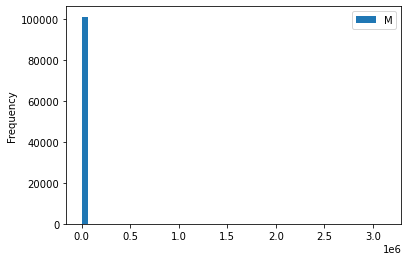

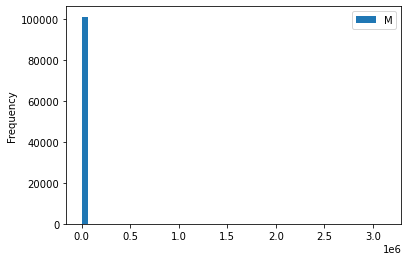

In [7]:
fig = df[df.M > 0].plot.hist(bins = 50).get_figure()
fig

In [8]:
quant = df[df.M>0].quantile([0,0.25,0.5,0.75,0.9,0.99,0.995,1])
quant

,M
0.000,4.00
0.250,8.00
0.500,32.00
0.750,136.00
0.900,660.00
0.990,15168.96
0.995,31976.84
1.000,3134160.00
